In [2]:
import numpy as np
import pandas as pd
import pygmo as pg
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import load_model
from sklearn.externals import joblib 

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
df=pd.read_csv('training_data_randn.csv', nrows=10000)
cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
col_y = 'is_deal'
col_p = 'Probability'
print(df.shape)

(10000, 22)


In [4]:
class propensity_predictor:
    def __init__(self, f_scalar_pickle, f_model_h5):
        self.f_scalar_pickle = f_scalar_pickle
        self.f_model_h5 = f_model_h5
        self.model = None
        
    def predict(self, X):
        if self.model is None:
            self.scalar = joblib.load(self.f_scalar_pickle)
            self.model = load_model(self.f_model_h5)            
        X_s = self.scalar.transform(X)
        y = self.model.predict(X_s)[:, 0]
        return y
    
    def __copy__(self):
        newone = type(self)(self.f_scalar_pickle, self.f_model_h5)
        return newone
    
    def __deepcopy__(self, memo):
        newone = type(self)(self.f_scalar_pickle, self.f_model_h5)
        return newone
    
m = propensity_predictor('x_scalar_randn.pkl', 'propensity_model_randn.h5')


In [5]:
%%timeit
m.predict(df[cols_x])

64.5 ms ± 4.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
df.loc[:, 'pred'] = m.predict(df[cols_x])

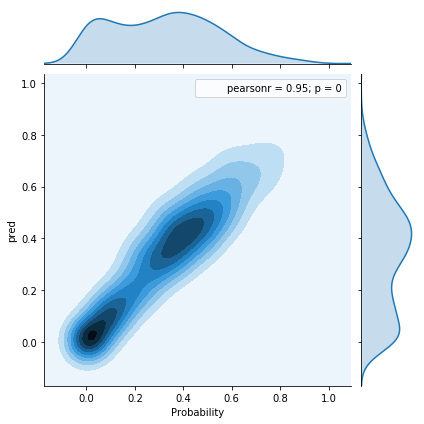

In [7]:
sns.jointplot(x=col_p, y='pred', data = df.iloc[:1000], kind="kde")

# Background

Linear programming vs non-linear programming

Optimization algorithms: local vs heuristic

# User Defined Problem (UDP)

## Objectives

In [42]:
f_discounts = np.arange(0, 0.21, 0.01)

In [43]:
for f in f_discounts:
    X = df[cols_x].values
    X[:, -1] = df['RRP']*f
    df.loc[:, 'y_pred_{:.02f}'.format(f)] = m.predict(X)

In [ ]:
def plot_

In [ ]:
df.groupby('product_id').apply()

## Single-objective optimization

Find out the discount amount for each product in order to maximize revenue

In [ ]:
# class optimal_discount_per_product_for_max_revenue:
#     def __init__(self, df, model): 
#         self.cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
#         self.df_X = df[self.cols_x+ ['product_id',]]     
#         self.p_ids = df['product_id'].unique()
#         self.n_products = len(self.p_ids)
#         self.max_discounts_ratio = (df.Discount/df.RRP).max()
#         self.model = model
        
#     def fitness(self, dv): # fitness given decision vector (dv)
#         prod_discount = dict(zip(self.p_ids, dv))
#         v_dis = self.df_X['product_id'].map(prod_discount) * self.df_X['RRP']
#         X = self.df_X[self.cols_x].values
#         X[:, -1] = v_dis
#         y = self.model.predict(self.df_X[self.cols_x])
#         return y
        
#     def get_bounds(self): # box bounds of decision vector (dv)
#         return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [ ]:
class optimal_discount_per_product_for_max_revenue:
    def __init__(self, df, model): 
        cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
        self.X = df[cols_x].values     
        self.x_products_id = df['product_id']
        self.p_ids = df['product_id'].unique()
        self.n_products = len(self.p_ids)
        self.max_discounts_ratio = (df.Discount/df.RRP).max()
        self.model = predictor('x_scalar_randn.pkl', 'elasticity_model_randn.h5')
        
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        self.X[:, -1] = self.x_products_id.map(prod_discount) * self.X[:, -2]
        y_prob = self.model.predict(self.X)
        revenue = y_prob.dot(self.X[:, -2] - self.X[:, -1])  
        return [-revenue,]
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [ ]:
pp_rev = optimal_discount_per_product_for_max_revenue(df, m)

In [ ]:
for v in np.arange(0, 0.2, 0.02):
    print(v, round(-pp_rev.fitness([v,]*5)[0]))

In [ ]:
prob = pg.problem(pp_rev)
algo = pg.algorithm(pg.de(gen = 100))
pop = pg.population(prob,10)


In [ ]:
pop = algo.evolve(pop)

In [ ]:
best_x_rev = pop.champion_x
best_f_rev = pop.champion_f
print(best_x_rev, best_f_rev) 

## Multi-objective optimization

In [10]:
class optimal_discount_per_product_for_max_revenue_min_cost:
    def __init__(self, df, model): 
        cols_x = ['nPurchases', 'nPurchasesDiscount', 'AvgPrice', 'AvgService', 'AvgDiscount', 'CLV', 'Service', 'RRP', 'Discount']
        self.X = df[cols_x].values     
        self.x_products_id = df['product_id']
        self.x_cost = df['Cost']
        self.p_ids = df['product_id'].unique()
        self.n_products = len(self.p_ids)
        self.max_discounts_ratio = (df.Discount/df.RRP).max()
        self.model = model
    
    def get_nobj(self):
        return 2
    
    def fitness(self, dv): # fitness given decision vector (dv)
        prod_discount = dict(zip(self.p_ids, dv))
        self.X[:, -1] = self.x_products_id.map(prod_discount) * self.X[:, -2]
        y_prob = self.model.predict(self.X)
        revenue = y_prob.dot(self.X[:, -2] - self.X[:, -1])  
        cost = y_prob.dot(self.x_cost)
        return [-revenue,-cost]
    
    def get_bounds(self): # box bounds of decision vector (dv)       
        return ([0,]*self.n_products, [self.max_discounts_ratio, ]*self.n_products)

In [11]:
pp_rev_cost = optimal_discount_per_product_for_max_revenue_min_cost(df, m)

In [12]:
for v in np.arange(0, 0.2, 0.02):
    print(v, -np.asarray(pp_rev_cost.fitness([v,]*5)).round())

0.0 [ 3400893. -1364435.]
0.02 [ 3339541. -1363657.]
0.04 [ 3348306. -1393762.]
0.06 [ 3474014. -1479358.]
0.08 [ 3749202. -1639967.]
0.1 [ 4113978. -1846031.]
0.12 [ 4423793. -2023478.]
0.14 [ 4583097. -2129857.]
0.16 [ 4592098. -2171691.]
0.18 [ 4495902. -2170817.]


In [13]:
prob = pg.problem(pp_rev_cost)
pop = pg.population(prob,32)

In [14]:
algo = pg.algorithm(pg.nsga2(gen = 100))
algo.set_verbosity(5)

In [15]:
%%time
pop = algo.evolve(pop)

Wall time: 4min 18s


In [16]:
fits, vectors = -pop.get_f(), pop.get_x()
ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fits)

In [17]:
idx_sorted = fits.argsort(0)[:, 0]

In [18]:
fits[idx_sorted]

array([[ 3339896.96058607, -1351187.55644077],
       [ 3348602.94304101, -1352643.30897859],
       [ 3403108.84302131, -1392760.37757826],
       [ 3477629.65334742, -1417224.29551777],
       [ 3535957.65105173, -1438568.96432814],
       [ 3563678.61336758, -1450466.02251701],
       [ 3649452.20557549, -1475595.1444291 ],
       [ 3661285.39379813, -1490150.71923002],
       [ 3762520.87536161, -1545055.01128768],
       [ 3803565.91326665, -1559013.45471468],
       [ 3819200.27053928, -1570228.89657743],
       [ 3861616.38559051, -1604909.30620376],
       [ 3993450.21374072, -1651578.9262584 ],
       [ 4039495.8365048 , -1694007.12698144],
       [ 4100217.77544957, -1717620.64017075],
       [ 4117509.72898321, -1733626.98279577],
       [ 4230126.67179946, -1794719.13384921],
       [ 4250976.51354396, -1833436.6318983 ],
       [ 4268832.53470934, -1845570.23395014],
       [ 4318646.12854459, -1876203.12517489],
       [ 4350804.83896325, -1904290.92138876],
       [ 4359

In [28]:
vectors[idx_sorted].round(2)

array([[0.  , 0.01, 0.  , 0.03, 0.  ],
       [0.  , 0.01, 0.  , 0.02, 0.  ],
       [0.  , 0.01, 0.07, 0.02, 0.  ],
       [0.08, 0.01, 0.  , 0.  , 0.  ],
       [0.09, 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.13, 0.  , 0.01, 0.  ],
       [0.01, 0.15, 0.  , 0.03, 0.  ],
       [0.  , 0.16, 0.07, 0.01, 0.  ],
       [0.08, 0.16, 0.01, 0.  , 0.  ],
       [0.09, 0.16, 0.  , 0.02, 0.  ],
       [0.1 , 0.16, 0.06, 0.03, 0.  ],
       [0.15, 0.15, 0.  , 0.01, 0.  ],
       [0.08, 0.16, 0.13, 0.  , 0.01],
       [0.13, 0.15, 0.11, 0.02, 0.01],
       [0.14, 0.15, 0.11, 0.03, 0.01],
       [0.15, 0.16, 0.14, 0.01, 0.01],
       [0.15, 0.13, 0.12, 0.01, 0.19],
       [0.15, 0.13, 0.13, 0.01, 0.19],
       [0.15, 0.16, 0.14, 0.01, 0.19],
       [0.15, 0.16, 0.16, 0.  , 0.2 ],
       [0.13, 0.14, 0.11, 0.1 , 0.  ],
       [0.15, 0.16, 0.12, 0.1 , 0.01],
       [0.15, 0.16, 0.14, 0.1 , 0.  ],
       [0.15, 0.16, 0.14, 0.11, 0.01],
       [0.15, 0.16, 0.11,

In [20]:
log = algo.extract(pg.nsga2).get_log()

In [24]:
hv=pg.hypervolume(fits)

In [26]:
hv.refpoint()

array([ 4664851.20868233, -1351187.55644077])

## Optimization with constraint

## Integer problem

## Optimization with gradient/hessian

## Logging during training

log = algo.extract(pg.nlopt).get_log()
from matplotlib import pyplot as plt 
plt.semilogy([line[0] for line in log], [line[1] for line in log], label = "obj") 
plt.semilogy([line[0] for line in log], [line[3] for line in log], label = "con")
